In [1]:
import FuncionRequisicion as rq
import FuncionReporte as rp
import pandas as pd
import numpy as np
import openpyxl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from pathlib import Path
from docxtpl import DocxTemplate, InlineImage
import datetime
from statistics import mean
import uuid
from datetime import datetime
import nltk
import json
import tflearn
import pickle
import telebot
from nltk.stem.lancaster import LancasterStemmer
stemmer=LancasterStemmer()
import random
from telebot.types import ReplyKeyboardMarkup
from telebot.types import ForceReply
from Token import *
from dateutil.relativedelta import relativedelta


Instructions for updating:
non-resource variables are not supported in the long term
curses is not supported on this machine (please install/reinstall curses for an optimal experience)


In [2]:
#Guardamos nuestro dataset en una variable
envio = pd.read_csv('delivery_dataset.csv', sep=';')
envioReal = envio.copy()



In [3]:
# Eliminamos los datos nulos y los cambiamos por valores útiles.
lista_index=[]
lista_value=[]
for x, i in enumerate(envioReal["Actual_Shipment_Time"].isna()):
    if i == True:
        lista_index.append(x)
        lista_value.append(i)

for i in lista_index:
    envioReal["Actual_Shipment_Time"][i] = envioReal["Planned_Shipment_Time"][i]

lista_index=[]
lista_value=[]
for x, i in enumerate(envioReal["Shipment_Delay"].isna()):
    if i == True:
        lista_index.append(x)
        lista_value.append(i)

for i in lista_index:
    envioReal["Shipment_Delay"][i] = 0

lista_index=[]
lista_value=[]
for x, i in enumerate(envioReal["Delivery_Status"].isna()):
    if i == True:
        lista_index.append(x)
        lista_value.append(i)

for i in lista_index:
    envioReal["Delivery_Status"][i] = 1

C:\Users\yulu1\AppData\Local\Temp\ipykernel_19140\2394921274.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  envioReal["Actual_Shipment_Time"][i] = envioReal["Planned_Shipment_Time"][i]
C:\Users\yulu1\AppData\Local\Temp\ipykernel_19140\2394921274.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  envioReal["Shipment_Delay"][i] = 0
C:\Users\yulu1\AppData\Local\Temp\ipykernel_19140\2394921274.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

In [4]:
#Creamos dos datasets de solamente los 5 paises donde más se mandan pedidos y los destinos.
sources1 = envioReal[ envioReal['Source'] == 'LAS'  ]
sources2 = envioReal[ envioReal['Source'] == 'MDW'  ]
sources3 = envioReal[ envioReal['Source'] == 'PHX'  ]
sources4 = envioReal[ envioReal['Source'] == 'OAK'  ]
sources5 = envioReal[ envioReal['Source'] == 'HOU'  ]

destination1 = envioReal[ envioReal['Destination'] == 'LAS'  ]
destination2 = envioReal[ envioReal['Destination'] == 'MDW'  ]
destination3 = envioReal[ envioReal['Destination'] == 'PHX'  ]
destination4 = envioReal[ envioReal['Destination'] == 'OAK'  ]
destination5 = envioReal[ envioReal['Destination'] == 'BWI'  ]

sources = pd.concat( [ sources1, sources2, sources3, sources4, sources5 ] )
destination = pd.concat([ destination1, destination2, destination3, destination4, destination5 ])


#Calculamos el promedio de cada uno de los source que seleccionamos
dfSour = envioReal[envioReal['Source']=='LAX']
dfLAS = dfSour[dfSour['Destination']=='LAS']
dfMDW = dfSour[dfSour['Destination']=='MDW']
dfPHX = dfSour[dfSour['Destination']=='PHX']
dfOAK = dfSour[dfSour['Destination']=='OAK']
dfHOU = dfSour[dfSour['Destination']=='HOU']

dest = pd.concat([dfLAS, dfMDW, dfPHX, dfOAK, dfHOU])

destt=['Source', 'Destination', 'Carrier_Name', 'Planned_Delivery_Time', 'Distance']

envioc=dest.loc[:,destt]

Las = envioc[ envioc['Destination'] == 'LAS' ].mean()
Mdw = envioc[ envioc['Destination'] == 'MDW' ].mean()
Phx = envioc[ envioc['Destination'] == 'PHX' ].mean()
Oak = envioc[ envioc['Destination'] == 'OAK' ].mean()
Hou = envioc[ envioc['Destination'] == 'HOU' ].mean()

PLas =int(Las['Planned_Delivery_Time'].mean())
PMdw =int(Phx['Planned_Delivery_Time'].mean())
PPhx =int(Mdw['Planned_Delivery_Time'].mean())
POak =int(Oak['Planned_Delivery_Time'].mean())
PHou =int(Hou['Planned_Delivery_Time'].mean())

#DataFrame de envios para las cotizaciones, en las cuales se guarda el promedio del tiempo de delivery.

deliveryProm=pd.DataFrame({'Source': ['LAX', 'LAX', 'LAX', 'LAX', 'LAX'], 
           'Destination': ['LAS', 'MDW', 'PHX', 'OAK', 'HOU'],
           'Carrier_name': ['WN', 'WN', 'WN', 'WN', 'WN'],
           'Planned_Delivery_Time': [PLas, PMdw, PPhx, POak, PHou],
           'Distance': [236, 1750, 370, 337, 1390]},
            columns = ['Source', 'Destination', 'Carrier_name', 'Planned_Delivery_Time', 'Distance'])


C:\Users\yulu1\AppData\Local\Temp\ipykernel_19140\4203896532.py:32: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  Las = envioc[ envioc['Destination'] == 'LAS' ].mean()
C:\Users\yulu1\AppData\Local\Temp\ipykernel_19140\4203896532.py:33: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  Mdw = envioc[ envioc['Destination'] == 'MDW' ].mean()
C:\Users\yulu1\AppData\Local\Temp\ipykernel_19140\4203896532.py:34: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In 

In [5]:
#Función para transformar de minutos a dias

def transformarMinutosADia( minutos ):
    horas = minutos/60
    dias = round(horas/24)
    
    return dias
  


In [6]:
#Función para crear el formar de la fecha
def current_date_format(date):
    day = date.day
    month = date.month
    year = date.year
    messsage = "{}-{} del {}".format(day, month, year)

    return messsage

In [7]:
#Función para verificar el nombre del producto
productos = pd.read_excel('productos.xlsx')
productos.set_index('product')
productosTienda = list(productos['product'])

def verificarNombre( nombre ):
    if nombre in productosTienda:
        return True
    else: 
        return False
        
        



In [8]:
#Función para verificar el stock
def verificarStock( nombre, cantidad ):
    print(cantidad)
    aux = productos.loc[ productos['product'] == nombre, 'stock']   
    aux2 = productosTienda.index( nombre ) 
    stock = aux[aux2] 

    if( stock >= cantidad ):
        return True
    else:
        return False
        

In [9]:
#Función para verificar el destino
def verificarDestino( destino ):
    destination = deliveryProm['Destination'].unique()
    if destino in destination:
        return True
    else:
        return False

In [10]:
#Función para disminutir stock


def disminuirStock( nombres, cantidad):
    for x, nombre in  enumerate(nombres):
        productos.loc[ productos['product'] == nombre, 'stock' ] = productos.loc[ productos['product'] == nombre, 'stock' ] - cantidad[x]
    
    productos.to_excel('productos.xlsx', engine='openpyxl',index=False)

--------------- DATOS PARA EL REPORTE ------------------

In [11]:
#Creación de datos para el reporte y las gráficas

deliveryDelay = envioReal['Shipment_Delay'].mean() 
productTotal = len(envioReal)
pedidosPerdidos = envio['Actual_Shipment_Time'].isna().sum()


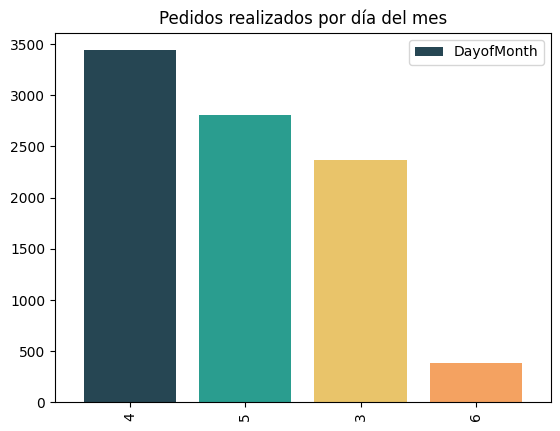

In [12]:
#Gráficas que muestra el día que se realizó más pedidos
colores = ['#264653','#2A9D8F','#E9C46A', '#F4A261', '#E76F51']
envioReal['DayofMonth'].value_counts().plot( kind = 'bar', width= 0.8, color = colores, title='Pedidos realizados por día del mes', legend=True)
plt.savefig('grafica1.jpg')


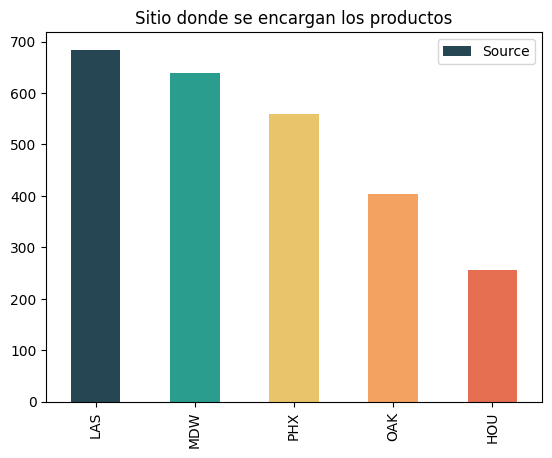

In [13]:
#Gráfica de los lugares donde más encargan producto
colores = ['#264653','#2A9D8F','#E9C46A', '#F4A261', '#E76F51']
sources['Source'].value_counts().plot( kind = 'bar', color = colores, legend=True, title='Sitio donde se encargan los productos')

plt.savefig('grafica2.jpg')

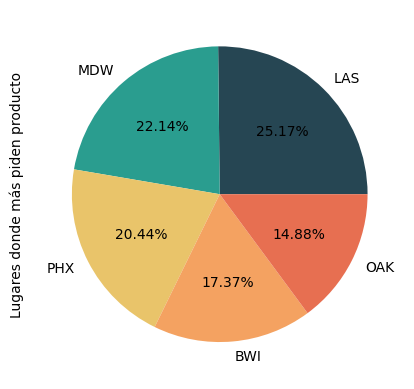

In [14]:
#Gráfica de los lugares donde más piden producto
colores = ['#264653','#2A9D8F','#E9C46A', '#F4A261', '#E76F51',]
destination['Destination'].value_counts().plot.pie( autopct = "%.2f%%", colors = colores, ylabel="Lugares donde más piden producto" )

plt.savefig('grafica3.jpg')


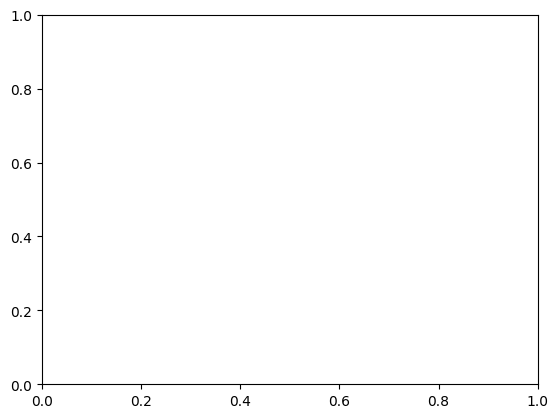

In [15]:
#Se crea el reporte mensual
rp.crearReporte()

----------------------------- BOT ---------------------------

In [16]:
#Tratamiento del lenguaje natural
with open("Frases.json", encoding='utf-8') as files:
    frases=json.load(files)

try:
    with open("Variables.pickle","rb") as archivoPickle_nuevo:
        palabras_a_usar, etiquetas, train, output = pickle.load(archivoPickle_nuevo)  

except:
    palabras_a_usar=[]
    etiquetas=[]
    auxX=[]
    auxY=[]


    nltk.download('punkt')



    for content in frases["contenido"]:
        for patrones in content["patrones"]:
                auxPalabra=nltk.word_tokenize(patrones)
                palabras_a_usar.extend(auxPalabra)
                auxX.append(auxPalabra)
                auxY.append(content["tag"])
                if content["tag"] not in etiquetas:
                    etiquetas.append(content["tag"])


    palabras_a_usar=[stemmer.stem(w.lower()) for w in palabras_a_usar if w!= "?"]

    palabras_a_usar=sorted(list(set(palabras_a_usar)))
    etiquetas=sorted(etiquetas)

    train=[]
    output=[]
    salidaVacia=[0 for _ in range(len(etiquetas))]




    for x, documento in enumerate(auxX):
            cubeta=[]
            auxPalabra=[stemmer.stem(w.lower()) for w in documento]
            for w in palabras_a_usar:
                if w in auxPalabra:
                    cubeta.append(1)
                else:
                    cubeta.append(0)
            filasalida=salidaVacia[:]
            filasalida[etiquetas.index(auxY[x])]=1
            train.append(cubeta)
            output.append(filasalida)
            


    train=np.array(train)
    output=np.array(output)
    with open("variables_nuevas.pickle", "wb") as archivoPickle:
        pickle.dump((palabras_a_usar, etiquetas,train, output ), archivoPickle )

In [17]:
#Creación del modelo
red=tflearn.input_data(shape=[None,len(train[0])])
red=tflearn.fully_connected(red, len(output))
red=tflearn.fully_connected(red,len(output))
red=tflearn.fully_connected(red,len(output[0]), activation="softmax") 
red=tflearn.regression(red)

modelo=tflearn.DNN(red)
try:
     modelo.load("modelo_bot.tflearn")

except:
    
     modelo.fit(train, output, n_epoch=1000, batch_size=len(output), show_metric=True)
     modelo.save("modelo_bot.tflearn")

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
INFO:tensorflow:Restoring parameters from c:\Users\yulu1\Documents\HackatonS\modelo_bot.tflearn


In [18]:
#Variables globales
doc=open("Cotizacion.docx", "rb")
reporte = open("Reporte_Mensual_Enero.docx", "rb")
excelP = open("productos.xlsx", "rb")
dataset = open("delivery_dataset.csv", "rb")
usuario = False
name_lastname = ''
producto_name= []
cantidadProducto=[]
productoAux = ''
destino = ''
deliveryTime = {
    'LAS': { int(PLas) } , 'MDW': int(PMdw), 'PHX': int(PPhx), 'OAK': int(POak), 'HOU': int(PHou)
}
distance = {
    'LAS': 236, 'MDW': 1750, 'PHX': 370, 'OAK': 337, 'HOU': 1390
}
nombreAsesoria = ''
datesAsesoria = datetime.now()
fechaAsesoria = current_date_format(datesAsesoria)
fechaAsesoria2 = fechaVencimiento = current_date_format( datetime.now() + relativedelta( days=7 )  ) 
numAsesoria = random.randrange(1, 100000, 1)


In [19]:
#Creación del bot
bot=telebot.TeleBot(Token) 

In [20]:
#Comandos de usuario
@bot.message_handler(commands=["admin"])
def cmd_admin(message):
     
     markup=ForceReply()
     mensaje=bot.send_message(message.chat.id, "Ingrese su nombre de administrador", reply_markup=markup)
     
     bot.register_next_step_handler(mensaje, is_admin)

def is_admin(message): #Funcion reservada para admins 
    global usuario
    with open("Usuarios.json", "r+") as File:
            File=json.load(File)

    if [message.text] in File["usuarios"]["Users"]:
          bot.send_message(message.chat.id, "Usuario logeado")
          usuario = True
    else:
        bot.send_message(message.chat.id, "Usuario no encontrado")
        usuario = False

In [21]:
#Comandos de ayuda.
@bot.message_handler(commands=["start", "help", "ayuda"])
def cmd_start(message):
     bot.send_message(message.chat.id, "Hola que tal, soy Tommy su bot-asistente, los comandos disponibles son: /cotizacion\n/reporte\n/productos\n/datos\n/asesoria")

In [22]:
#Comando de reporte
@bot.message_handler(commands=["reporte"])
def cmd_reporte(message):
     markup=ForceReply()
     respuesta =  bot.send_message(message.chat.id, "Escribe ok para realizar el tramite", reply_markup=markup)
     bot.register_next_step_handler(respuesta, verificar)

#Verificar usuario
def verificar(message):
    global usuario
    if( usuario == False ):
          bot.send_message(message.chat.id, 'No estás registrado, por favor escribe /admin')
          return
    else:
        global reporte
        bot.send_document(message.chat.id, reporte)



In [23]:
#Comando ExcelProductos
@bot.message_handler(commands=["productos"])
def cmd_productos(message):
     markup=ForceReply()
     respuesta =  bot.send_message(message.chat.id, "Escribe ok para realizar el tramite", reply_markup=markup)
     bot.register_next_step_handler(respuesta, verificar2)

def verificar2(message):
    global usuario
    if( usuario == False ):
          bot.send_message(message.chat.id, 'No estás registrado, por favor escribe /admin')
          return
    else:
        global excelP
        bot.send_document(message.chat.id, excelP)


In [24]:
#Comando Dataset
@bot.message_handler(commands=["datos"])
def cmd_Datos(message):
     markup=ForceReply()
     respuesta =  bot.send_message(message.chat.id, "Escribe ok para realizar el tramite", reply_markup=markup)
     bot.register_next_step_handler(respuesta, verificar3)

def verificar3(message):
    global usuario
    if( usuario == False ):
          bot.send_message(message.chat.id, 'No estás registrado, por favor escribe /admin')
          return
    else:
        global dataset
        bot.send_document(message.chat.id, dataset)

In [25]:
# Asesoria
@bot.message_handler(commands=["asesoria"])
def cmd_asesoria(message):
     markup=ForceReply()
     response=bot.send_message(message.chat.id, "Ingrese su nombre y apellido", reply_markup=markup)
     bot.register_next_step_handler(response,crearAsesoria)

def crearAsesoria(message):
     markup=ForceReply()
     global nombreAsesoria
     global fechaAsesoria2
     nombreAsesoria = message.text
     response=bot.send_message(message.chat.id, f" {nombreAsesoria} Su cita de asesioria ha sido agendada para el día { fechaAsesoria2 } con el numero { numAsesoria } ( guarde este numero para futuras referencias )", reply_markup=markup)
     

In [26]:
#Series de comando de Cotización

@bot.message_handler(commands=["cotizacion"])
def cmd_cotizacion(message):
     markup=ForceReply()
     nombre_apellido=bot.send_message(message.chat.id, "Ingrese su nombre y apellido", reply_markup=markup)
     bot.register_next_step_handler(nombre_apellido,name_product)

def name_product(message):
     global name_lastname
     global productosTienda
     nombre = message.text
     name_lastname = nombre
     markup=ForceReply()
     bot.send_message(message.chat.id, "Excelente!, ahora")
     name=bot.send_message(message.chat.id, f"ingrese el nombre de su producto:\n1. caja de mascarilla \n2. caja de cloro \n3. paquete de gel desinfectante \n4. paquete de toallas humedas", reply_markup=markup)
     bot.register_next_step_handler(name, cmd_verificarProducto)

def cmd_verificarProducto(message):
     global producto_name
     global productoAux
     productoAux = message.text
     markup=ForceReply()
     result = verificarNombre( productoAux )
     if not ( result ):
          name=bot.send_message(message.chat.id, f" El producto introducido no existe, vuelva a ingresar su producto.\n1. caja de mascarilla \n2. caja de cloro \n3. paquete de gel desinfectante \n4. paquete de toallas humedas", reply_markup=markup)
          bot.register_next_step_handler(name, cmd_verificarProducto)
     else:
          producto_name.append( productoAux )
          cant_productos=bot.send_message(message.chat.id, f"Ingrese la cantidad de { productoAux } que desea", reply_markup=markup)
          bot.register_next_step_handler(cant_productos, cmd_verificarCantidad )


def cmd_verificarCantidad(message):
     global producto_name
     global cantidadProducto
     markup=ForceReply()
     cantidadAux = message.text

     if not cantidadAux.isdigit():
          cant_productos=bot.send_message(message.chat.id, f"Valor invalido, ingrese nuevamente la cantidad de { productoAux } que desea", reply_markup=markup)
          bot.register_next_step_handler(cant_productos, cmd_verificarCantidad )
     else:
          cantidadAux = int( cantidadAux )


     result = verificarStock( productoAux, cantidadAux )

     if not ( result ):
          cant_productos=bot.send_message(message.chat.id, f"No hay stock suficiente, ingrese nuevamente la cantidad de { productoAux } que desea", reply_markup=markup)
          bot.register_next_step_handler(cant_productos, cmd_verificarCantidad )
     else:
          cantidadProducto.append( cantidadAux )
          destination = deliveryProm['Destination'].unique()
          listaDestinos = ''
          for x in destination:
               listaDestinos += x + '\n'

          response = bot.send_message( message.chat.id, f'¿Desea agregar más productos a su cotización? responda con: "si" o "no"',  reply_markup=markup )
          bot.register_next_step_handler(response, cmd_verificarCarrito )

def cmd_verificarCarrito(message):
     markup=ForceReply()
     decision = message.text

     if( decision == 'si' ):
           productoAux = ''
           name=bot.send_message(message.chat.id, f"ingrese el nombre de su producto:\n1. caja de mascarilla \n2. caja de cloro \n3. paquete de gel desinfectante \n4. paquete de toallas humedas", reply_markup=markup)
           bot.register_next_step_handler(name, cmd_verificarProducto)

     else:
          destination = deliveryProm['Destination'].unique()
          listaDestinos = ''
          for x in destination:
               listaDestinos += x + '\n'
          destin=bot.send_message(message.chat.id, f"Elige la localización donde desee recibir el producto {listaDestinos} ", reply_markup=markup)
          bot.register_next_step_handler(destin, cmd_verificarDestino)

def cmd_verificarDestino(message):
     global destino
     markup=ForceReply()
     destino = message.text
     result = verificarDestino( destino )

     if not ( result ):
          destination = deliveryProm['Destination'].unique()
          listaDestinos = ''
          for x in destination:
               listaDestinos += x + '\n'
          destin = bot.send_message( message.chat.id, f"Localizacion no encontrada, vuelva a elegir una localizacion donde desee el producto: { listaDestinos }", reply_markup=markup)
          bot.register_next_step_handler(destin, cmd_verificarDestino )          
     else:
          mensaje = bot.send_message( message.chat.id, 'Listo, se creará su cotización', reply_markup=markup )
          bot.register_next_step_handler(mensaje, create_cotizacion)

def create_cotizacion(message):
     global name_lastname
     global producto_name
     global cantidadProducto
     global destino
     global deliveryTime

     tiempo = deliveryTime[destino]
     dias = transformarMinutosADia( tiempo ) 

     rq.crearCotizacion( name_lastname, list(producto_name) , list(cantidadProducto), destino, 'WN', dias, distance[destino])
     disminuirStock( producto_name, cantidadProducto )
     salida=bot.send_message(message.chat.id, "Cotización creada, escriba cualquier valor para recibirla")
     bot.register_next_step_handler(salida, send_document)

    
def send_document(message):
     markup=ForceReply()
     doc=open("Cotizacion.docx", "rb")
     bot.send_document(message.chat.id, doc)
     global name_lastname
     global producto_name
     global cantidadProducto
     global productoAux
     productoAux = ''
     name_lastname=''
     producto_name=[]
     cantidadProducto=[]

In [27]:
#Funcion de procesamiento de lenguaje natural y respuesta acorde a lo entrenado
@bot.message_handler(content_types=["text"])
def greetings(message):

        msg=message.text

        cubeta=[0 for _ in range(len(palabras_a_usar))]
        enterProcessed=nltk.word_tokenize(msg)
        enterProcessed=[stemmer.stem(word.lower()) for word in enterProcessed]
        for singleWord in enterProcessed:
            for i, word in enumerate(palabras_a_usar):
                if word == singleWord:
                    cubeta[i]=1
        resultados=modelo.predict([np.array(cubeta)])
        
        resultadosIndices=np.argmax(resultados)
        tag=etiquetas[resultadosIndices]


        for tagAux in frases["contenido"]:
            if tagAux["tag"] == tag:
                    respuesta=tagAux["respuestas"]
                    respuesta_real=random.choice(respuesta)
        if max(cubeta) == 0:
            bot.send_message(message.chat.id,'No entiendo lo que dices')
            bot.send_message(message.chat.id, "Para conocer nuestros comandos, ingresa /help ")
        else:
            bot.send_message(message.chat.id,respuesta_real)
            bot.send_message(message.chat.id, "En que te puedo ayudar?")

In [28]:
if __name__ == '__main__':
    print('iniciando el bot')
    bot.infinity_polling()
    #inicio=threading.Thread(name="inicio", target=iniciar_bot)
#    inicio.start()
    print('fin')    

iniciando el bot
1
1-2-2023
[12, '', '', '', '']
[12.0]
3
1-2-2023
[12, '', '', '', '']
[36.0]
